# start

In [1]:
TGT='Reply'
PRFX='Reply0521A1'

trntmstmp=1584412344
tsttmstmp=1590075806

tm_trn_min,tm_trn_max=(1580947200, 1581551999)
tm_tst_min,tm_tst_max=(1581552000, 1582156799)

train_total=148075238
test_total=int(1.4e7)
print(f'train_total {train_total:,}, test_total {test_total:,}')

SEED=101

trnsz = int(1e6)
valsz = trnsz//10
print(f'train_total {trnsz:,}, valsz {valsz:,}')



import datetime
def showtm(tm): return datetime.datetime.fromtimestamp(tm).strftime('%Y-%m-%d %H:%M:%S')
print([showtm(tm) for tm in (trntmstmp, tsttmstmp)])
print([showtm(tm) for tm in (tm_trn_min,tm_trn_max)])
print([showtm(tm) for tm in (tm_tst_min,tm_tst_max)])

train_total 148,075,238, test_total 14,000,000
train_total 1,000,000, valsz 100,000
['2020-03-17 02:32:24', '2020-05-21 15:43:26']
['2020-02-06 00:00:00', '2020-02-12 23:59:59']
['2020-02-13 00:00:00', '2020-02-19 23:59:59']


# setup

In [2]:
from tqdm import tqdm
import time
from pathlib import Path
from collections import Counter,defaultdict
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
import pickle
# import xgboost as xgb
import lightgbm as lgb
import category_encoders as ce
import gc

import optuna
# optuna.logging.CRITICAL, optuna.logging.FATAL
# optuna.logging.ERROR
# optuna.logging.WARNING, optuna.logging.WARN
# optuna.logging.INFO
# optuna.logging.DEBUG
# optuna.logging.set_verbosity(optuna.logging.ERROR)
import optuna.integration.lightgbm as lgb
optuna.logging.disable_default_handler()


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

def iou(s1,s2):
    return len(s1&s2) / len(s1|s2)

HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

# https://towardsdatascience.com/how-to-calibrate-undersampled-model-scores-8f3319c1ea5b
# How to use the function?
# Let’s say your goal is to generate a model that shows the credit default probabilities and your original 
# training data has 50,000 rows with only 500 of them labeled as target class. When you sample your non-target 
# instances randomly and reduce the total row count to 10,000, while conserving 500 target rows, our calibration
# function becomes:
# calibration(model_results, 50000, 500, 10000, 500)
# Here model_results is your model probability output array. After you train your model and put the results in it, your function is ready to use. 
def calibration(data, train_pop, target_pop, sampled_train_pop, sampled_target_pop):
    calibrated_data = ((data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop)) /
    (((1 - data) * (1 - target_pop / train_pop) / (1 - sampled_target_pop / sampled_train_pop)) +
     (data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop))))
    return calibrated_data


cols=['toks','hshtgs','twtid','media','links','domns','twttyp','lang','tm','u1id','u1_fllwer_cnt','u1_fllwing_cnt','u1_vrfed','u1_create_tm','u2id','u2_fllwer_cnt','u2_fllwng_cnt','u2_vrfed','u2_create_tm','u1_fllw_u2','reply_tm','retwt_tm','retwt_cmmnt_tm','like_tm',]

cols_val = cols[:-4]
cols_tgt_tmstmp=[ 'retwt_tm', 'reply_tm', 'like_tm', 'retwt_cmmnt_tm',]
cols_tgt=[o.split('_tm')[0] for o in cols_tgt_tmstmp]
tgts             = ['Retweet','Reply','Like','RTwCmnt',]
assert cols_tgt == ['retwt',  'reply','like','retwt_cmmnt',]
tgt2col = dict(zip(tgts, cols_tgt))
TCOL=tgt2col[TGT]
print('TCOL', TCOL)
print(tgt2col)

TCOL reply
{'Retweet': 'retwt', 'Reply': 'reply', 'Like': 'like', 'RTwCmnt': 'retwt_cmmnt'}


# prep

In [3]:
def prp_tgt(df):
    df[cols_tgt]=df[cols_tgt_tmstmp].notna()
    df.drop(columns=cols_tgt_tmstmp, inplace=True)
    display(df[cols_tgt].mean())

In [4]:
%%time
dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=valsz)
print(dfval.shape)
prp_tgt(dfval)

(100000, 24)


retwt          0.11211
reply          0.02754
like           0.43929
retwt_cmmnt    0.00801
dtype: float64

CPU times: user 1.15 s, sys: 172 ms, total: 1.32 s
Wall time: 1.34 s


## maybe oversample

In [5]:
# df = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=5)
# dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=2)
# dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,skiprows=2,nrows=3)
# display(df.twtid)
# display(dfval.twtid)
# display(dftrn.twtid)

# 0    D4D1EBDE74F74C5DA529959AF979625C
# 1    BFB529DAB6D384EB83E899A72AB3830D
# 2    519078C7834E9642508F72A6C2D0F3B7
# 3    52AAE9E33EFAC8C478C57B31A9E31ED1
# 4    89C1298C55EB3D68E2784F0BFB69E6F8
# Name: twtid, dtype: object
# 0    D4D1EBDE74F74C5DA529959AF979625C
# 1    BFB529DAB6D384EB83E899A72AB3830D
# Name: twtid, dtype: object
# 0    519078C7834E9642508F72A6C2D0F3B7
# 1    52AAE9E33EFAC8C478C57B31A9E31ED1
# 2    89C1298C55EB3D68E2784F0BFB69E6F8
# Name: twtid, dtype: object

In [6]:
%%time
if TGT in ('Retweet','Like'): trnpop=trnsz
if TGT=='Reply': trnpop=trnsz*3.7
if TGT=='RTwCmnt': trnpop=trnsz*11.5
assert trnpop<train_total

dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,
                     skiprows=valsz, nrows=trnpop)
print(dftrn.shape)
prp_tgt(dftrn)

(3700000, 24)


retwt          0.113006
reply          0.027500
like           0.439600
retwt_cmmnt    0.007701
dtype: float64

CPU times: user 45.6 s, sys: 5.32 s, total: 50.9 s
Wall time: 53.5 s


In [7]:
train_pop=len(dftrn)
sampled_train_pop=trnsz
idx_pos = np.where(dftrn[TCOL])[0]
target_pop=sampled_target_pop=len(idx_pos)
if TGT in ('Reply','RTwCmnt'):
    idx_neg0 = np.where(~dftrn[TCOL])[0]
    idx_neg = np.random.choice(idx_neg0, trnsz-len(idx_pos), replace=False)
    idx = np.concatenate([idx_pos,idx_neg])
    dftrn = dftrn.iloc[idx].copy()
print(dftrn.shape, dftrn[TCOL].mean())
print(train_pop, target_pop, sampled_train_pop, sampled_target_pop)

display(dftrn.head())
display(dftrn.columns)

(1000000, 24) 0.101749
3700000 101749 1000000 101749


,toks,hshtgs,twtid,media,links,domns,twttyp,lang,tm,u1id,u1_fllwer_cnt,u1_fllwing_cnt,u1_vrfed,u1_create_tm,u2id,u2_fllwer_cnt,u2_fllwng_cnt,u2_vrfed,u2_create_tm,u1_fllw_u2,retwt,reply,like,retwt_cmmnt
5,101\t1434\t107854\t18260\t31904\t111431\t74759...,NaN,0EB15633A8CC0A6E3917C272F43E6DF3,NaN,NaN,NaN,TopLevel,022EC308651FACB02794A8147AEE1B78,1581218899,A7E00C86B4E3709D589754A51042A360,1198215,662,True,1246548812,016212C070A76EAB37E8ED93CA509BA9,0,42,False,1578271262,False,False,True,False,False
51,101\t10473\t10116\t10132\t12603\t97953\t25307\...,NaN,7C71C144E7B9F2D87F1F4DDB40AB1C49,NaN,NaN,NaN,TopLevel,2996EB2FE8162C076D070A4C8D6532CD,1581203618,B0CBECD53C3B945C875C55DDFF56D13F,1424,854,False,1394906655,01625341E5A48963E5AA7DFFDC4436D4,643,327,False,1372760933,True,False,True,False,False
63,101\t56898\t137\t24362\t131\t100\t196\t36351\t...,NaN,ADCF033A7C7087C1506E2BC3E2D8F092,NaN,NaN,NaN,Retweet,717293301FE296B0B61950D041485825,1581258397,ECD90FC37F0A7C15C82834FDDEEDC21A,1753,811,False,1568347799,01625CCEC5A4C322FC247DB9E223CC08,147,1355,False,1355850070,False,False,True,False,False
75,101\t12441\t105702\t793\t61783\t34022\t60578\t...,NaN,7EB0824DDA3D28844CC0FF65B7C4AA08,NaN,NaN,NaN,TopLevel,167115458A0DBDFF7E9C0C53A83BAC9B,1581271814,D905F31F909CC63C2BBEB7F6B43487FE,175998,116,False,1466830888,01626B64A2570C2807AB97716262FBA9,90,139,False,1364278366,False,False,True,False,False
83,101\t69532\t10107\t12372\t10160\t19048\t136\t1...,NaN,0A95516F028EBFF6B551DB32C4B2D1B5,Video,NaN,NaN,TopLevel,ECED8A16BE2A5E8871FD55F4842F16B1,1581214010,88E80BAB56E6F59E4EF012A8B12D3BAE,8825,8024,False,1557262802,0162759D8908AA8C849F06086A023D85,26265,24215,False,1557422269,True,False,True,False,False


Index(['toks', 'hshtgs', 'twtid', 'media', 'links', 'domns', 'twttyp', 'lang',
       'tm', 'u1id', 'u1_fllwer_cnt', 'u1_fllwing_cnt', 'u1_vrfed',
       'u1_create_tm', 'u2id', 'u2_fllwer_cnt', 'u2_fllwng_cnt', 'u2_vrfed',
       'u2_create_tm', 'u1_fllw_u2', 'retwt', 'reply', 'like', 'retwt_cmmnt'],
      dtype='object')

## prep and features

In [8]:
def prp_df(df, tm_max):
    '''
    tm_max = tm_trn_max for train tm_tst_max for test
    '''
    lendf = len(df)
    print(dtnow(), 'start')
    set_u1 = set(df.u1id)
    set_u2 = set(df.u2id)
    df['u1inu2']=df.u1id.isin(set_u2)
    df['u2inu1']=df.u2id.isin(set_u1)

    #counts
    df['len_toks'] = df.toks.apply(lambda x: len(x.split('\t')))
    df.drop(columns=['toks'], inplace=True)    
    for m in ['Photo', 'Video', 'GIF']:
        df[f'n_media_{m}'] = df['media'].fillna('').apply(lambda x: x.split('\t').count(m))
    tgnms = ['hshtgs','media', 'links', 'domns',]
    for tgnm in tgnms:
        df[f'has_{tgnm}']=df[tgnm].notna()
        df[f'lst_{tgnm}'] = df[tgnm].fillna('').apply(lambda x: x.split('\t') if len(x) else [])
        df[f'n_{tgnm}'] = df[f'lst_{tgnm}'].apply(len)  
    df.drop(columns=['has_links','n_links'], inplace=True) #duplicates has_domns,n_domns 
    
    #time
    dt = pd.to_datetime(df.tm, unit='s')
    df['dayofweek'] = dt.dt.dayofweek
    df['hour'] = dt.dt.hour
    
    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm
    df['tmdlta_twtu1'] = df.tm - df.u1_create_tm
    df['tmdlta_twtu2'] = df.tm - df.u2_create_tm

    df['twt_age']   = tm_max-df.tm
    df['u1_age']    = tm_max-df.u1_create_tm
    df['u2_age']    = tm_max-df.u2_create_tm
    df.drop(columns=['tm', 'u1_create_tm', 'u2_create_tm'], inplace=True)

    #time derived
    df['u1_fllwer_cnt_by_age'] = df.u1_fllwer_cnt / df.u1_age
    df['u1_fllwng_cnt_by_age'] = df.u2_fllwng_cnt / df.u2_age
    
    #interaction
    df['u1u2']=df.u1id+'_'+df.u2id
    df['langhour']=df.lang+'_'+df.hour.astype(str)
    

#     #freq of feature values
#     print(dtnow(), 'freq of columns using CountEncoder')
#     encoder = ce.CountEncoder()
#     encoded = encoder.fit_transform(
#     df[['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwing_cnt', 'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_vrfed', 'u1_fllw_u2', 
#        'n_media_Photo', 'n_media_Video', 'n_media_GIF', 
#        'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media','has_domns', 'n_domns', 
#        'dayofweek', 'hour', 'u1u2', 'langhour']].astype(object))
#     encoded = encoded.astype(int)/lendf
#     encoded.columns = [f'frq_{col}' for col in encoded.columns]
#     df = pd.concat([df,encoded],1)
    
    #freq of tgnm values
#     print(dtnow(), 'freq of tags')
#     for tgnm in tgnms:
#         vs = [j for i in df[f'lst_{tgnm}'] for j in i]
#         cnt = Counter(vs)
#         frq = {k:v/lendf for k,v in cnt.items()}
#         df[f'sumfrq_{tgnm}']=df[f'lst_{tgnm}'].apply(lambda x: sum([frq.get(o,0) for o in x]))
#         df[f'maxfrq_{tgnm}']=df[f'lst_{tgnm}'].apply(lambda x: max([frq.get(o,0) for o in x]) if len(x) else 0)
    
    df.drop(columns=tgnms+[f'lst_{tgnm}' for tgnm in tgnms],inplace=True)

    print(dtnow(), 'done')
    return df

In [9]:
%%time
dftrn=prp_df(dftrn, tm_max=tm_trn_max)

2020-05-21 18:33:38 start
2020-05-21 18:34:16 done
CPU times: user 34.5 s, sys: 3.01 s, total: 37.5 s
Wall time: 38.2 s


In [10]:
%%time
dfval=prp_df(dfval, tm_max=tm_trn_max)

2020-05-21 18:34:16 start
2020-05-21 18:34:19 done
CPU times: user 2.29 s, sys: 65.6 ms, total: 2.36 s
Wall time: 2.72 s


## tr vl split

In [11]:
msk_vl=np.random.rand(len(dftrn))<0.15
idxvl=np.where( msk_vl)[0]
idxtr=np.where(~msk_vl)[0]

dftr = dftrn.iloc[idxtr].copy()
dfvl = dftrn.iloc[idxvl].copy()
del dftrn

gc.collect()

30

In [12]:
cols_category=['twttyp', 'lang', 'langhour']
for df in dftr,dfvl,dfval:
    df.drop(columns=['twtid','u1id','u2id','u1u2'], inplace=True)
    df[cols_category]=df[cols_category].astype('category')

In [13]:
cols_feat = [col for col in dftr.columns if col not in cols_tgt]

# model

## cols_feat

In [14]:
cols_feat

['twttyp',
 'lang',
 'u1_fllwer_cnt',
 'u1_fllwing_cnt',
 'u1_vrfed',
 'u2_fllwer_cnt',
 'u2_fllwng_cnt',
 'u2_vrfed',
 'u1_fllw_u2',
 'u1inu2',
 'u2inu1',
 'len_toks',
 'n_media_Photo',
 'n_media_Video',
 'n_media_GIF',
 'has_hshtgs',
 'n_hshtgs',
 'has_media',
 'n_media',
 'has_domns',
 'n_domns',
 'dayofweek',
 'hour',
 'tmdlta_u2u1',
 'tmdlta_twtu1',
 'tmdlta_twtu2',
 'twt_age',
 'u1_age',
 'u2_age',
 'u1_fllwer_cnt_by_age',
 'u1_fllwng_cnt_by_age',
 'langhour']

In [15]:
print(len(cols_feat))


32


In [16]:
results = {}
results['PRFX'] = PRFX
results['TGT'] = TGT
results['cols_feat'] = cols_feat

In [17]:
params={
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': 0,    
}

results['params'] = params

In [18]:
%%time
dtr = lgb.Dataset(dftr[cols_feat], label=dftr[TCOL])
dvl = lgb.Dataset(dfvl[cols_feat], label=dfvl[TCOL])
best_params, tuning_history = {}, []
evalres = {}
evallist = [(dtr, 'train'), (dvl, 'eval')]
bst = lgb.train(params=params, 
                train_set=dtr, 
                num_boost_round=50000,
                valid_sets=[dtr, dvl],
                valid_names=['tr','vl'],
                best_params=best_params,
                tuning_history=tuning_history,
                verbose_eval=100,
                early_stopping_rounds=100,
                evals_result=evalres,
               )
results['bst'] = bst
results['evalres'] = evalres
results['best_params']=best_params
results['tuning_history']=tuning_history

/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/optuna/_experimental.py:87: ExperimentalWarning: train is experimental (supported from v0.18.0). The interface can change in the future.
  ExperimentalWarning
tune_feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.27631	vl's binary_logloss: 0.282385
[200]	tr's binary_logloss: 0.272664	vl's binary_logloss: 0.281833
[300]	tr's binary_logloss: 0.269383	vl's binary_logloss: 0.28159
[400]	tr's binary_logloss: 0.266424	vl's binary_logloss: 0.281568
Early stopping, best iteration is:
[357]	tr's binary_logloss: 0.267722	vl's binary_logloss: 0.281537


tune_feature_fraction, val_score: 0.281537:  14%|#4        | 1/7 [03:57<23:44, 237.36s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.275493	vl's binary_logloss: 0.282224
[200]	tr's binary_logloss: 0.271773	vl's binary_logloss: 0.281849
[300]	tr's binary_logloss: 0.268478	vl's binary_logloss: 0.281704
[400]	tr's binary_logloss: 0.265347	vl's binary_logloss: 0.281669
Early stopping, best iteration is:
[330]	tr's binary_logloss: 0.267489	vl's binary_logloss: 0.281612


tune_feature_fraction, val_score: 0.281537:  29%|##8       | 2/7 [05:41<16:26, 197.29s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.275217	vl's binary_logloss: 0.282346
[200]	tr's binary_logloss: 0.271113	vl's binary_logloss: 0.281979
[300]	tr's binary_logloss: 0.267679	vl's binary_logloss: 0.28189
[400]	tr's binary_logloss: 0.264385	vl's binary_logloss: 0.281859
Early stopping, best iteration is:
[355]	tr's binary_logloss: 0.265852	vl's binary_logloss: 0.2818


tune_feature_fraction, val_score: 0.281537:  43%|####2     | 3/7 [07:02<10:49, 162.45s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.274626	vl's binary_logloss: 0.282274
[200]	tr's binary_logloss: 0.270284	vl's binary_logloss: 0.281907
[300]	tr's binary_logloss: 0.266501	vl's binary_logloss: 0.281972
Early stopping, best iteration is:
[229]	tr's binary_logloss: 0.269132	vl's binary_logloss: 0.281855


tune_feature_fraction, val_score: 0.281537:  57%|#####7    | 4/7 [09:08<07:34, 151.63s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273586	vl's binary_logloss: 0.282512
[200]	tr's binary_logloss: 0.268788	vl's binary_logloss: 0.282469
Early stopping, best iteration is:
[177]	tr's binary_logloss: 0.26976	vl's binary_logloss: 0.282386


tune_feature_fraction, val_score: 0.281537:  71%|#######1  | 5/7 [11:30<04:57, 148.78s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.272847	vl's binary_logloss: 0.282742
[200]	tr's binary_logloss: 0.268041	vl's binary_logloss: 0.28266
Early stopping, best iteration is:
[173]	tr's binary_logloss: 0.269153	vl's binary_logloss: 0.282592


tune_feature_fraction, val_score: 0.281537:  86%|########5 | 6/7 [12:04<01:54, 114.30s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.272386	vl's binary_logloss: 0.282925
[200]	tr's binary_logloss: 0.267048	vl's binary_logloss: 0.282954
Early stopping, best iteration is:
[136]	tr's binary_logloss: 0.270164	vl's binary_logloss: 0.282814


tune_num_leaves, val_score: 0.281537:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.263728	vl's binary_logloss: 0.281265
Early stopping, best iteration is:
[85]	tr's binary_logloss: 0.265613	vl's binary_logloss: 0.281216


tune_num_leaves, val_score: 0.281216:   5%|5         | 1/20 [00:35<11:06, 35.05s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.257704	vl's binary_logloss: 0.281362
Early stopping, best iteration is:
[77]	tr's binary_logloss: 0.261722	vl's binary_logloss: 0.281327


tune_num_leaves, val_score: 0.281216:  10%|#         | 2/20 [01:49<14:00, 46.68s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.258974	vl's binary_logloss: 0.281432
Early stopping, best iteration is:
[71]	tr's binary_logloss: 0.263834	vl's binary_logloss: 0.281304


tune_num_leaves, val_score: 0.281216:  15%|#5        | 3/20 [07:46<39:39, 139.98s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.257704	vl's binary_logloss: 0.281362
Early stopping, best iteration is:
[77]	tr's binary_logloss: 0.261722	vl's binary_logloss: 0.281327


tune_num_leaves, val_score: 0.281216:  20%|##        | 4/20 [14:51<1:00:08, 225.53s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.272631	vl's binary_logloss: 0.281681
[200]	tr's binary_logloss: 0.267555	vl's binary_logloss: 0.281446
[300]	tr's binary_logloss: 0.26341	vl's binary_logloss: 0.281565
Early stopping, best iteration is:
[212]	tr's binary_logloss: 0.267018	vl's binary_logloss: 0.281416


tune_num_leaves, val_score: 0.281216:  25%|##5       | 5/20 [19:37<1:00:53, 243.57s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.269469	vl's binary_logloss: 0.281343
[200]	tr's binary_logloss: 0.262881	vl's binary_logloss: 0.281246
Early stopping, best iteration is:
[149]	tr's binary_logloss: 0.265891	vl's binary_logloss: 0.281164


tune_num_leaves, val_score: 0.281164:  30%|###       | 6/20 [20:25<43:09, 184.98s/it]  

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.257146	vl's binary_logloss: 0.281551
Early stopping, best iteration is:
[83]	tr's binary_logloss: 0.259861	vl's binary_logloss: 0.281374


tune_num_leaves, val_score: 0.281164:  35%|###5      | 7/20 [21:22<31:44, 146.49s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.257545	vl's binary_logloss: 0.281349
Early stopping, best iteration is:
[85]	tr's binary_logloss: 0.260025	vl's binary_logloss: 0.2812


tune_num_leaves, val_score: 0.281164:  40%|####      | 8/20 [25:01<33:38, 168.18s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.271567	vl's binary_logloss: 0.281644
[200]	tr's binary_logloss: 0.265957	vl's binary_logloss: 0.281441
[300]	tr's binary_logloss: 0.261099	vl's binary_logloss: 0.281471
Early stopping, best iteration is:
[209]	tr's binary_logloss: 0.26549	vl's binary_logloss: 0.281386


tune_num_leaves, val_score: 0.281164:  45%|####5     | 9/20 [27:25<29:29, 160.91s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.254297	vl's binary_logloss: 0.281489
Early stopping, best iteration is:
[71]	tr's binary_logloss: 0.260236	vl's binary_logloss: 0.281309


tune_num_leaves, val_score: 0.281164:  50%|#####     | 10/20 [30:05<26:46, 160.65s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.278938	vl's binary_logloss: 0.283083
[200]	tr's binary_logloss: 0.276162	vl's binary_logloss: 0.282407
[300]	tr's binary_logloss: 0.273859	vl's binary_logloss: 0.281968
[400]	tr's binary_logloss: 0.271906	vl's binary_logloss: 0.281803
[500]	tr's binary_logloss: 0.269958	vl's binary_logloss: 0.281524
[600]	tr's binary_logloss: 0.268298	vl's binary_logloss: 0.281456
Early stopping, best iteration is:
[584]	tr's binary_logloss: 0.268577	vl's binary_logloss: 0.281428


tune_num_leaves, val_score: 0.281164:  55%|#####5    | 11/20 [32:20<22:56, 153.00s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.265052	vl's binary_logloss: 0.281262
Early stopping, best iteration is:
[98]	tr's binary_logloss: 0.265258	vl's binary_logloss: 0.281238


tune_num_leaves, val_score: 0.281164:  60%|######    | 12/20 [34:03<18:24, 138.04s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.26537	vl's binary_logloss: 0.281315
Early stopping, best iteration is:
[92]	tr's binary_logloss: 0.266311	vl's binary_logloss: 0.281261


tune_num_leaves, val_score: 0.281164:  65%|######5   | 13/20 [37:07<17:43, 151.86s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.269383	vl's binary_logloss: 0.281385
[200]	tr's binary_logloss: 0.262433	vl's binary_logloss: 0.281334
Early stopping, best iteration is:
[198]	tr's binary_logloss: 0.262525	vl's binary_logloss: 0.281319


tune_num_leaves, val_score: 0.281164:  70%|#######   | 14/20 [38:48<13:38, 136.42s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.261358	vl's binary_logloss: 0.281181
Early stopping, best iteration is:
[93]	tr's binary_logloss: 0.262294	vl's binary_logloss: 0.281139


tune_num_leaves, val_score: 0.281139:  75%|#######5  | 15/20 [41:25<11:53, 142.67s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.261619	vl's binary_logloss: 0.281383
Early stopping, best iteration is:
[84]	tr's binary_logloss: 0.263847	vl's binary_logloss: 0.281314


tune_num_leaves, val_score: 0.281139:  80%|########  | 16/20 [42:24<07:50, 117.67s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268297	vl's binary_logloss: 0.281327
[200]	tr's binary_logloss: 0.261166	vl's binary_logloss: 0.28111
Early stopping, best iteration is:
[175]	tr's binary_logloss: 0.262768	vl's binary_logloss: 0.281074


tune_num_leaves, val_score: 0.281074:  85%|########5 | 17/20 [44:29<05:59, 119.81s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.28007	vl's binary_logloss: 0.2835
[200]	tr's binary_logloss: 0.277554	vl's binary_logloss: 0.282657
[300]	tr's binary_logloss: 0.275527	vl's binary_logloss: 0.282218
[400]	tr's binary_logloss: 0.273788	vl's binary_logloss: 0.28192
[500]	tr's binary_logloss: 0.272309	vl's binary_logloss: 0.281763
[600]	tr's binary_logloss: 0.270953	vl's binary_logloss: 0.281652
Early stopping, best iteration is:
[581]	tr's binary_logloss: 0.271178	vl's binary_logloss: 0.281644


tune_num_leaves, val_score: 0.281074:  90%|######### | 18/20 [47:42<04:43, 141.76s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.261757	vl's binary_logloss: 0.281204
[200]	tr's binary_logloss: 0.250511	vl's binary_logloss: 0.281412
Early stopping, best iteration is:
[108]	tr's binary_logloss: 0.260711	vl's binary_logloss: 0.281122


tune_num_leaves, val_score: 0.281074:  95%|#########5| 19/20 [52:35<03:07, 187.21s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.267626	vl's binary_logloss: 0.281379
[200]	tr's binary_logloss: 0.259678	vl's binary_logloss: 0.281138
Early stopping, best iteration is:
[198]	tr's binary_logloss: 0.259828	vl's binary_logloss: 0.281136


tune_num_leaves, val_score: 0.281074: 100%|##########| 20/20 [56:43<00:00, 170.18s/it]
tune_bagging_fraction_and_bagging_freq, val_score: 0.281074:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.270434	vl's binary_logloss: 0.28219
[200]	tr's binary_logloss: 0.26294	vl's binary_logloss: 0.282119
Early stopping, best iteration is:
[163]	tr's binary_logloss: 0.265552	vl's binary_logloss: 0.281942


tune_bagging_fraction_and_bagging_freq, val_score: 0.281074:  10%|#         | 1/10 [01:44<15:36, 104.08s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.270942	vl's binary_logloss: 0.282549
[200]	tr's binary_logloss: 0.263541	vl's binary_logloss: 0.282812
Early stopping, best iteration is:
[109]	tr's binary_logloss: 0.270218	vl's binary_logloss: 0.282491


tune_bagging_fraction_and_bagging_freq, val_score: 0.281074:  20%|##        | 2/10 [03:34<14:07, 105.94s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.27054	vl's binary_logloss: 0.282246
[200]	tr's binary_logloss: 0.263106	vl's binary_logloss: 0.282413
Early stopping, best iteration is:
[153]	tr's binary_logloss: 0.266355	vl's binary_logloss: 0.282152


tune_bagging_fraction_and_bagging_freq, val_score: 0.281074:  30%|###       | 3/10 [05:23<12:27, 106.76s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.269239	vl's binary_logloss: 0.281587
[200]	tr's binary_logloss: 0.261577	vl's binary_logloss: 0.281617
Early stopping, best iteration is:
[144]	tr's binary_logloss: 0.265638	vl's binary_logloss: 0.281446


tune_bagging_fraction_and_bagging_freq, val_score: 0.281074:  40%|####      | 4/10 [09:08<14:13, 142.19s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268967	vl's binary_logloss: 0.281773
[200]	tr's binary_logloss: 0.261491	vl's binary_logloss: 0.281413
Early stopping, best iteration is:
[175]	tr's binary_logloss: 0.263143	vl's binary_logloss: 0.281368


tune_bagging_fraction_and_bagging_freq, val_score: 0.281074:  50%|#####     | 5/10 [11:04<11:11, 134.40s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268447	vl's binary_logloss: 0.281421
[200]	tr's binary_logloss: 0.261135	vl's binary_logloss: 0.28135
Early stopping, best iteration is:
[180]	tr's binary_logloss: 0.26238	vl's binary_logloss: 0.281311


tune_bagging_fraction_and_bagging_freq, val_score: 0.281074:  60%|######    | 6/10 [12:03<07:26, 111.71s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268437	vl's binary_logloss: 0.281427
[200]	tr's binary_logloss: 0.261261	vl's binary_logloss: 0.281183
[300]	tr's binary_logloss: 0.255574	vl's binary_logloss: 0.28125
Early stopping, best iteration is:
[206]	tr's binary_logloss: 0.260903	vl's binary_logloss: 0.28112


tune_bagging_fraction_and_bagging_freq, val_score: 0.281074:  70%|#######   | 7/10 [17:08<08:29, 169.83s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.2685	vl's binary_logloss: 0.281679
[200]	tr's binary_logloss: 0.261137	vl's binary_logloss: 0.281429
[300]	tr's binary_logloss: 0.2546	vl's binary_logloss: 0.281524
Early stopping, best iteration is:
[208]	tr's binary_logloss: 0.260573	vl's binary_logloss: 0.281349


tune_bagging_fraction_and_bagging_freq, val_score: 0.281074:  80%|########  | 8/10 [19:14<05:13, 156.61s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.270302	vl's binary_logloss: 0.282066
[200]	tr's binary_logloss: 0.262641	vl's binary_logloss: 0.282127
Early stopping, best iteration is:
[138]	tr's binary_logloss: 0.267238	vl's binary_logloss: 0.281911


tune_bagging_fraction_and_bagging_freq, val_score: 0.281074:  90%|######### | 9/10 [22:28<02:47, 167.86s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.27011	vl's binary_logloss: 0.282159
[200]	tr's binary_logloss: 0.262482	vl's binary_logloss: 0.28219
Early stopping, best iteration is:
[144]	tr's binary_logloss: 0.266533	vl's binary_logloss: 0.28209


tune_bagging_fraction_and_bagging_freq, val_score: 0.281074: 100%|##########| 10/10 [24:32<00:00, 147.21s/it]
tune_feature_fraction, val_score: 0.281074:   0%|          | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268297	vl's binary_logloss: 0.281327
[200]	tr's binary_logloss: 0.261166	vl's binary_logloss: 0.28111
Early stopping, best iteration is:
[175]	tr's binary_logloss: 0.262768	vl's binary_logloss: 0.281074


tune_feature_fraction, val_score: 0.281074:  33%|###3      | 1/3 [02:47<05:33, 166.82s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268077	vl's binary_logloss: 0.281254
[200]	tr's binary_logloss: 0.2605	vl's binary_logloss: 0.28117
Early stopping, best iteration is:
[149]	tr's binary_logloss: 0.264122	vl's binary_logloss: 0.281124


tune_feature_fraction, val_score: 0.281074:  67%|######6   | 2/3 [03:57<02:18, 138.05s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.267697	vl's binary_logloss: 0.281654
Early stopping, best iteration is:
[92]	tr's binary_logloss: 0.268441	vl's binary_logloss: 0.281568


tune_feature_fraction, val_score: 0.281074: 100%|##########| 3/3 [05:19<00:00, 106.41s/it]
tune_lambda_l1_and_lambda_l2, val_score: 0.281074:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268684	vl's binary_logloss: 0.281328
[200]	tr's binary_logloss: 0.261882	vl's binary_logloss: 0.281119
[300]	tr's binary_logloss: 0.25529	vl's binary_logloss: 0.281106
Early stopping, best iteration is:
[213]	tr's binary_logloss: 0.261011	vl's binary_logloss: 0.281


tune_lambda_l1_and_lambda_l2, val_score: 0.281000:   5%|5         | 1/20 [00:20<06:29, 20.52s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268949	vl's binary_logloss: 0.281203
[200]	tr's binary_logloss: 0.262063	vl's binary_logloss: 0.280985
Early stopping, best iteration is:
[180]	tr's binary_logloss: 0.263407	vl's binary_logloss: 0.280912


tune_lambda_l1_and_lambda_l2, val_score: 0.280912:  10%|#         | 2/20 [00:34<05:32, 18.45s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.269033	vl's binary_logloss: 0.281447
[200]	tr's binary_logloss: 0.262375	vl's binary_logloss: 0.281189
[300]	tr's binary_logloss: 0.256847	vl's binary_logloss: 0.281184
Early stopping, best iteration is:
[203]	tr's binary_logloss: 0.262219	vl's binary_logloss: 0.281151


tune_lambda_l1_and_lambda_l2, val_score: 0.280912:  15%|#5        | 3/20 [00:48<04:51, 17.17s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268297	vl's binary_logloss: 0.281327
[200]	tr's binary_logloss: 0.261111	vl's binary_logloss: 0.281175
Early stopping, best iteration is:
[163]	tr's binary_logloss: 0.263567	vl's binary_logloss: 0.281105


tune_lambda_l1_and_lambda_l2, val_score: 0.280912:  20%|##        | 4/20 [01:00<04:09, 15.57s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.26813	vl's binary_logloss: 0.281403
[200]	tr's binary_logloss: 0.260887	vl's binary_logloss: 0.281234
Early stopping, best iteration is:
[171]	tr's binary_logloss: 0.262854	vl's binary_logloss: 0.281168


tune_lambda_l1_and_lambda_l2, val_score: 0.280912:  25%|##5       | 5/20 [01:12<03:39, 14.63s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.26832	vl's binary_logloss: 0.281393
[200]	tr's binary_logloss: 0.260911	vl's binary_logloss: 0.28119
[300]	tr's binary_logloss: 0.254456	vl's binary_logloss: 0.281232
Early stopping, best iteration is:
[243]	tr's binary_logloss: 0.258036	vl's binary_logloss: 0.28112


tune_lambda_l1_and_lambda_l2, val_score: 0.280912:  30%|###       | 6/20 [07:20<28:07, 120.52s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268297	vl's binary_logloss: 0.281327
[200]	tr's binary_logloss: 0.261166	vl's binary_logloss: 0.28111
Early stopping, best iteration is:
[175]	tr's binary_logloss: 0.262768	vl's binary_logloss: 0.281074


tune_lambda_l1_and_lambda_l2, val_score: 0.280912:  35%|###5      | 7/20 [10:54<32:10, 148.50s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268922	vl's binary_logloss: 0.281203
[200]	tr's binary_logloss: 0.261709	vl's binary_logloss: 0.281002
Early stopping, best iteration is:
[166]	tr's binary_logloss: 0.263932	vl's binary_logloss: 0.280948


tune_lambda_l1_and_lambda_l2, val_score: 0.280912:  40%|####      | 8/20 [25:44<1:14:11, 370.97s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.269542	vl's binary_logloss: 0.281186
[200]	tr's binary_logloss: 0.263437	vl's binary_logloss: 0.280868
[300]	tr's binary_logloss: 0.258855	vl's binary_logloss: 0.280838
Early stopping, best iteration is:
[223]	tr's binary_logloss: 0.262145	vl's binary_logloss: 0.280802


tune_lambda_l1_and_lambda_l2, val_score: 0.280802:  45%|####5     | 9/20 [27:41<54:03, 294.82s/it]  

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268133	vl's binary_logloss: 0.281406
[200]	tr's binary_logloss: 0.261127	vl's binary_logloss: 0.281344
[300]	tr's binary_logloss: 0.254345	vl's binary_logloss: 0.281654
Early stopping, best iteration is:
[202]	tr's binary_logloss: 0.261021	vl's binary_logloss: 0.281342


tune_lambda_l1_and_lambda_l2, val_score: 0.280802:  50%|#####     | 10/20 [32:53<50:00, 300.00s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268298	vl's binary_logloss: 0.281299
[200]	tr's binary_logloss: 0.260843	vl's binary_logloss: 0.281217
Early stopping, best iteration is:
[178]	tr's binary_logloss: 0.262406	vl's binary_logloss: 0.281182


tune_lambda_l1_and_lambda_l2, val_score: 0.280802:  55%|#####5    | 11/20 [33:07<32:07, 214.19s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.269279	vl's binary_logloss: 0.281329
[200]	tr's binary_logloss: 0.263221	vl's binary_logloss: 0.281136
[300]	tr's binary_logloss: 0.258088	vl's binary_logloss: 0.281194
Early stopping, best iteration is:
[236]	tr's binary_logloss: 0.261504	vl's binary_logloss: 0.281102


tune_lambda_l1_and_lambda_l2, val_score: 0.280802:  60%|######    | 12/20 [36:30<28:07, 211.00s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268421	vl's binary_logloss: 0.28147
Early stopping, best iteration is:
[84]	tr's binary_logloss: 0.26981	vl's binary_logloss: 0.281412


tune_lambda_l1_and_lambda_l2, val_score: 0.280802:  65%|######5   | 13/20 [37:37<19:33, 167.63s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.270304	vl's binary_logloss: 0.281196
[200]	tr's binary_logloss: 0.264149	vl's binary_logloss: 0.280758
Early stopping, best iteration is:
[188]	tr's binary_logloss: 0.26475	vl's binary_logloss: 0.280723


tune_lambda_l1_and_lambda_l2, val_score: 0.280723:  70%|#######   | 14/20 [39:52<15:46, 157.82s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.270459	vl's binary_logloss: 0.281277
[200]	tr's binary_logloss: 0.264571	vl's binary_logloss: 0.280937
Early stopping, best iteration is:
[171]	tr's binary_logloss: 0.266163	vl's binary_logloss: 0.280907


tune_lambda_l1_and_lambda_l2, val_score: 0.280723:  75%|#######5  | 15/20 [43:45<15:02, 180.56s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268324	vl's binary_logloss: 0.281398
[200]	tr's binary_logloss: 0.261191	vl's binary_logloss: 0.281229
[300]	tr's binary_logloss: 0.254458	vl's binary_logloss: 0.281343
Early stopping, best iteration is:
[211]	tr's binary_logloss: 0.260284	vl's binary_logloss: 0.281148


tune_lambda_l1_and_lambda_l2, val_score: 0.280723:  80%|########  | 16/20 [46:16<11:25, 171.47s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268388	vl's binary_logloss: 0.281333
[200]	tr's binary_logloss: 0.260852	vl's binary_logloss: 0.281164
[300]	tr's binary_logloss: 0.254303	vl's binary_logloss: 0.281284
Early stopping, best iteration is:
[223]	tr's binary_logloss: 0.25942	vl's binary_logloss: 0.281113


tune_lambda_l1_and_lambda_l2, val_score: 0.280723:  85%|########5 | 17/20 [54:23<13:18, 266.21s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268091	vl's binary_logloss: 0.28136
[200]	tr's binary_logloss: 0.260935	vl's binary_logloss: 0.2812
[300]	tr's binary_logloss: 0.254643	vl's binary_logloss: 0.281263
Early stopping, best iteration is:
[239]	tr's binary_logloss: 0.258438	vl's binary_logloss: 0.281131


tune_lambda_l1_and_lambda_l2, val_score: 0.280723:  90%|######### | 18/20 [54:42<06:23, 192.00s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268272	vl's binary_logloss: 0.281446
[200]	tr's binary_logloss: 0.260949	vl's binary_logloss: 0.28137
[300]	tr's binary_logloss: 0.254263	vl's binary_logloss: 0.281587
Early stopping, best iteration is:
[209]	tr's binary_logloss: 0.260242	vl's binary_logloss: 0.281315


tune_lambda_l1_and_lambda_l2, val_score: 0.280723:  95%|#########5| 19/20 [54:57<02:19, 139.04s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268598	vl's binary_logloss: 0.281456
[200]	tr's binary_logloss: 0.261402	vl's binary_logloss: 0.281254
Early stopping, best iteration is:
[164]	tr's binary_logloss: 0.263792	vl's binary_logloss: 0.281144


tune_lambda_l1_and_lambda_l2, val_score: 0.280723: 100%|##########| 20/20 [55:11<00:00, 165.55s/it]
tune_min_child_samples, val_score: 0.280723:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.270338	vl's binary_logloss: 0.281177
[200]	tr's binary_logloss: 0.264443	vl's binary_logloss: 0.280836
[300]	tr's binary_logloss: 0.259735	vl's binary_logloss: 0.280851
Early stopping, best iteration is:
[232]	tr's binary_logloss: 0.263039	vl's binary_logloss: 0.280723


tune_min_child_samples, val_score: 0.280723:  20%|##        | 1/5 [00:18<01:14, 18.66s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.270303	vl's binary_logloss: 0.281202
[200]	tr's binary_logloss: 0.264334	vl's binary_logloss: 0.280831
[300]	tr's binary_logloss: 0.259446	vl's binary_logloss: 0.280857
Early stopping, best iteration is:
[237]	tr's binary_logloss: 0.262437	vl's binary_logloss: 0.280787


tune_min_child_samples, val_score: 0.280723:  40%|####      | 2/5 [00:37<00:56, 18.77s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.270264	vl's binary_logloss: 0.281223
[200]	tr's binary_logloss: 0.26434	vl's binary_logloss: 0.280995
Early stopping, best iteration is:
[180]	tr's binary_logloss: 0.265445	vl's binary_logloss: 0.280953


tune_min_child_samples, val_score: 0.280723:  60%|######    | 3/5 [00:54<00:36, 18.23s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.270298	vl's binary_logloss: 0.281345
[200]	tr's binary_logloss: 0.264067	vl's binary_logloss: 0.280949
[300]	tr's binary_logloss: 0.259089	vl's binary_logloss: 0.281043
Early stopping, best iteration is:
[238]	tr's binary_logloss: 0.262233	vl's binary_logloss: 0.2809


tune_min_child_samples, val_score: 0.280723:  80%|########  | 4/5 [01:14<00:18, 18.66s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.270218	vl's binary_logloss: 0.281265
[200]	tr's binary_logloss: 0.264085	vl's binary_logloss: 0.280955
[300]	tr's binary_logloss: 0.259182	vl's binary_logloss: 0.281069
Early stopping, best iteration is:
[203]	tr's binary_logloss: 0.263937	vl's binary_logloss: 0.280928


tune_min_child_samples, val_score: 0.280723: 100%|##########| 5/5 [01:33<00:00, 18.70s/it]


CPU times: user 5h 38min 50s, sys: 1d 12h 29min 21s, total: 1d 18h 8min 11s
Wall time: 2h 35min 48s


## best_params

In [19]:
best_params

{'lambda_l1': 7.474588951612009,
 'lambda_l2': 8.518019330322753,
 'num_leaves': 91,
 'feature_fraction': 0.41600000000000004,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 5}

## tr vl trajec

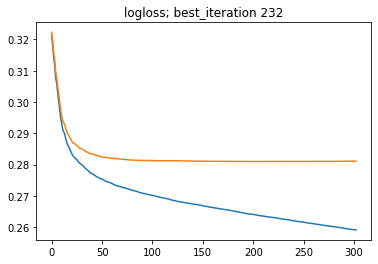

In [20]:
plt.plot(evalres['tr']['binary_logloss'])
plt.plot(evalres['vl']['binary_logloss'])
plt.title(f"logloss; best_iteration {bst.best_iteration}")
plt.show()

## model features

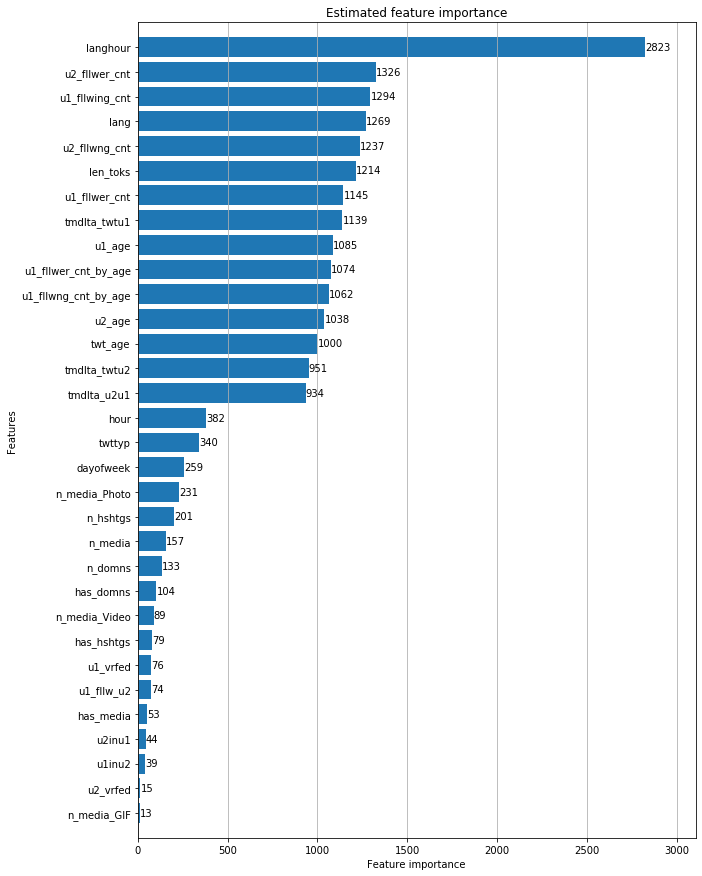

In [21]:
ax = lgb.plot_importance(bst, height=0.8, max_num_features=50, figsize=(10,15))
ax.grid(False, axis="y")
ax.set_title(f'Estimated feature importance')
plt.show()

In [22]:
pd.DataFrame([bst.feature_name(), bst.feature_importance()]).T.sort_values(1, ascending=False)

,0,1
31,langhour,2823
5,u2_fllwer_cnt,1326
3,u1_fllwing_cnt,1294
1,lang,1269
6,u2_fllwng_cnt,1237
11,len_toks,1214
2,u1_fllwer_cnt,1145
24,tmdlta_twtu1,1139
27,u1_age,1085
29,u1_fllwer_cnt_by_age,1074


In [23]:
col2imp = dict(zip(bst.feature_name(), bst.feature_importance()))
sorted(col2imp.items(), key=lambda x: -x[1])

[('langhour', 2823),
 ('u2_fllwer_cnt', 1326),
 ('u1_fllwing_cnt', 1294),
 ('lang', 1269),
 ('u2_fllwng_cnt', 1237),
 ('len_toks', 1214),
 ('u1_fllwer_cnt', 1145),
 ('tmdlta_twtu1', 1139),
 ('u1_age', 1085),
 ('u1_fllwer_cnt_by_age', 1074),
 ('u1_fllwng_cnt_by_age', 1062),
 ('u2_age', 1038),
 ('twt_age', 1000),
 ('tmdlta_twtu2', 951),
 ('tmdlta_u2u1', 934),
 ('hour', 382),
 ('twttyp', 340),
 ('dayofweek', 259),
 ('n_media_Photo', 231),
 ('n_hshtgs', 201),
 ('n_media', 157),
 ('n_domns', 133),
 ('has_domns', 104),
 ('n_media_Video', 89),
 ('has_hshtgs', 79),
 ('u1_vrfed', 76),
 ('u1_fllw_u2', 74),
 ('has_media', 53),
 ('u2inu1', 44),
 ('u1inu2', 39),
 ('u2_vrfed', 15),
 ('n_media_GIF', 13)]

In [24]:
[o[0] for o in sorted(col2imp.items(), key=lambda x: -x[1]) if o[1]>0]

['langhour',
 'u2_fllwer_cnt',
 'u1_fllwing_cnt',
 'lang',
 'u2_fllwng_cnt',
 'len_toks',
 'u1_fllwer_cnt',
 'tmdlta_twtu1',
 'u1_age',
 'u1_fllwer_cnt_by_age',
 'u1_fllwng_cnt_by_age',
 'u2_age',
 'twt_age',
 'tmdlta_twtu2',
 'tmdlta_u2u1',
 'hour',
 'twttyp',
 'dayofweek',
 'n_media_Photo',
 'n_hshtgs',
 'n_media',
 'n_domns',
 'has_domns',
 'n_media_Video',
 'has_hshtgs',
 'u1_vrfed',
 'u1_fllw_u2',
 'has_media',
 'u2inu1',
 'u1inu2',
 'u2_vrfed',
 'n_media_GIF']

# eval

In [25]:
%%time
prdtr = bst.predict(dftr[cols_feat],num_iteration=bst.best_iteration)
prdvl = bst.predict(dfvl[cols_feat],num_iteration=bst.best_iteration)
prdval0 = bst.predict(dfval[cols_feat],num_iteration=bst.best_iteration)
prdval = calibration(prdval0, train_pop, target_pop, sampled_train_pop, sampled_target_pop)

CPU times: user 1min 17s, sys: 14.3 s, total: 1min 31s
Wall time: 6.35 s


In [26]:
%%time
ytr,yvl,yval=[df[TCOL].values for df in (dftr,dfvl,dfval)]

auc_tr=compute_prauc(prdtr, ytr)
rce_tr=compute_rce(prdtr, ytr)
auc_vl=compute_prauc(prdvl, yvl)
rce_vl=compute_rce(prdvl, yvl)
auc_val=compute_prauc(prdval, yval)
rce_val=compute_rce(prdval, yval)

results['scrs'] = {}
results['scrs']['auc_tr']=auc_tr
results['scrs']['rce_tr']=rce_tr
results['scrs']['auc_vl']=auc_vl
results['scrs']['rce_vl']=rce_vl
results['scrs']['auc_val']=auc_val
results['scrs']['rce_val']=rce_val

CPU times: user 3.96 s, sys: 1.05 s, total: 5.01 s
Wall time: 3.45 s


In [27]:
print(f'auc_tr:  {auc_tr:.4f}')
print(f'auc_vl:  {auc_vl:.4f}')
print(f'auc_val: {auc_val:.4f}')
print()
print(f'rce_tr:  {rce_tr:.4f}')
print(f'rce_vl:  {rce_vl:.4f}')
print(f'rce_val: {rce_val:.4f}')

auc_tr:  0.3789
auc_vl:  0.3023
auc_val: 0.1123

rce_tr:  19.9867
rce_vl:  14.8911
rce_val: 11.9265


## score

In [28]:
print(f'-{auc_val:.4f}-{rce_val:.4f}')

-0.1123-11.9265


# save results

In [29]:
pickle.dump(results, open(f'{p_out}/results_{PRFX}.p', 'wb'))

# infer

In [30]:
results = pickle.load( open(f'{p_out}/results_{PRFX}.p', 'rb'))
bst = results['bst']
cols_feat = results['cols_feat']

## prep

In [31]:
%%time
dftst=pd.read_csv(
    f'{p_in}/val_{tsttmstmp}.tsv',
    sep='\x01', header=None, names=cols_val, 
#     nrows=10
)

CPU times: user 1min 23s, sys: 10.3 s, total: 1min 34s
Wall time: 1min 30s


In [32]:
dftst.shape

(12434735, 20)

In [33]:
%%time
dftst=prp_df(dftst, tm_max=tm_tst_max)

2020-05-21 21:11:52 start
2020-05-21 21:17:14 done
CPU times: user 4min 28s, sys: 48.6 s, total: 5min 16s
Wall time: 5min 22s


In [34]:
dftst.drop(columns=['u1id','u1u2'], inplace=True)
cols_category=['twttyp', 'lang', 'langhour']
dftst[cols_category]=dftst[cols_category].astype('category')

## predict

In [35]:
%%time
prdtst0 = bst.predict(dftst[cols_feat],num_iteration=bst.best_iteration)
prdtst = calibration(prdtst0, train_pop, target_pop, sampled_train_pop, sampled_target_pop)

CPU times: user 14min 47s, sys: 21 s, total: 15min 8s
Wall time: 1min 57s


In [36]:
dfsub_ids = dftst[['twtid','u2id',]]
dfsub = dfsub_ids.copy()
dfsub['scr'] = prdtst
dfsub.to_csv(f'{p_out}/{TGT}__{PRFX}.csv',index=False,header=False)